In [15]:
# import necessary modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

# Set up notebook for better display
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)


In [2]:
# read the data from analysis\data\015_Contracts_Full.csv file into a pandas dataframe
df = pd.read_csv('data/015_Contracts_Full.csv')

df.head()

,contract_transaction_unique_key,contract_award_unique_key,award_id_piid,modification_number,transaction_number,parent_award_agency_id,parent_award_agency_name,parent_award_id_piid,parent_award_modification_number,federal_action_obligation,total_dollars_obligated,total_outlayed_amount_for_overall_award,base_and_exercised_options_value,current_total_value_of_award,base_and_all_options_value,potential_total_value_of_award,disaster_emergency_fund_codes_for_overall_award,outlayed_amount_from_COVID-19_supplementals_for_overall_award,obligated_amount_from_COVID-19_supplementals_for_overall_award,outlayed_amount_from_IIJA_supplemental_for_overall_award,obligated_amount_from_IIJA_supplemental_for_overall_award,action_date,action_date_fiscal_year,period_of_performance_start_date,period_of_performance_current_end_date,period_of_performance_potential_end_date,ordering_period_end_date,solicitation_date,awarding_agency_code,awarding_agency_name,awarding_sub_agency_code,awarding_sub_agency_name,awarding_office_code,awarding_office_name,funding_agency_code,funding_agency_name,funding_sub_agency_code,funding_sub_agency_name,funding_office_code,funding_office_name,treasury_accounts_funding_this_award,federal_accounts_funding_this_award,object_classes_funding_this_award,program_activities_funding_this_award,foreign_funding,foreign_funding_description,sam_exception,sam_exception_description,recipient_uei,recipient_duns,recipient_name,recipient_name_raw,recipient_doing_business_as_name,cage_code,recipient_parent_uei,recipient_parent_duns,recipient_parent_name,recipient_parent_name_raw,recipient_country_code,recipient_country_name,recipient_address_line_1,recipient_address_line_2,recipient_city_name,prime_award_transaction_recipient_county_fips_code,recipient_county_name,prime_award_transaction_recipient_state_fips_code,recipient_state_code,recipient_state_name,recipient_zip_4_code,prime_award_transaction_recipient_cd_original,prime_award_transaction_recipient_cd_current,recipient_phone_number,recipient_fax_number,primary_place_of_performance_country_code,primary_place_of_performance_country_name,primary_place_of_performance_city_name,prime_award_transaction_place_of_performance_county_fips_code,primary_place_of_performance_county_name,prime_award_transaction_place_of_performance_state_fips_code,primary_place_of_performance_state_code,primary_place_of_performance_state_name,primary_place_of_performance_zip_4,prime_award_transaction_place_of_performance_cd_original,prime_award_transaction_place_of_performance_cd_current,award_or_idv_flag,award_type_code,award_type,idv_type_code,idv_type,multiple_or_single_award_idv_code,multiple_or_single_award_idv,type_of_idc_code,type_of_idc,type_of_contract_pricing_code,type_of_contract_pricing,transaction_description,prime_award_base_transaction_description,action_type_code,action_type,solicitation_identifier,number_of_actions,inherently_governmental_functions,inherently_governmental_functions_description,product_or_service_code,product_or_service_code_description,contract_bundling_code,contract_bundling,dod_claimant_program_code,dod_claimant_program_description,naics_code,naics_description,recovered_materials_sustainability_code,recovered_materials_sustainability,domestic_or_foreign_entity_code,domestic_or_foreign_entity,dod_acquisition_program_code,dod_acquisition_program_description,information_technology_commercial_item_category_code,information_technology_commercial_item_category,epa_designated_product_code,epa_designated_product,country_of_product_or_service_origin_code,country_of_product_or_service_origin,place_of_manufacture_code,place_of_manufacture,subcontracting_plan_code,subcontracting_plan,extent_competed_code,extent_competed,solicitation_procedures_code,solicitation_procedures,type_of_set_aside_code,type_of_set_aside,evaluated_preference_code,evaluated_preference,research_code,research,fair_opportunity_limited_sources_code,fair_opportunity_limited_sources,other_than_full_and_open_competition_code,

In [11]:
# Define fields to select
fields = [
    "recipient_name",
    "recipient_name_raw",
    "recipient_parent_name", 
    "recipient_parent_name_raw", 
    "awarding_sub_agency_name",
    "awarding_office_name",
    "funding_sub_agency_name",
    "funding_office_name",
    "period_of_performance_start_date",
    "period_of_performance_current_end_date",
    "naics_description",
    "product_or_service_code_description",
    "award_id_piid",
    "parent_award_id_piid",
    "modification_number",
    "action_date",
    "federal_action_obligation"
]

# Define top contractors to analyze
top_contractors = [
"Deloitte",
"Accenture Federal Services",
"Booz Allen Hamilton",
"General Dynamics",
"Leidos",
"Guidehouse",
"Hill Mission Technologies Corp.",
"Science Applications International Corporation",
"CGI Federal",
"International Business Machines Corporation"
]

# select only the fields we need
df_narrow = df[fields]

# Filter data to include only top contractors
# Create a function to check if any top contractor name is part of a string
def contains_top_contractor(text):
    if pd.isna(text):
        return False
    text = text.lower()
    for contractor in top_contractors:
        if contractor.lower() in text or text in contractor.lower():
            return True
    return False

# Apply the function to create filters for each column
name_filter = df_narrow['recipient_name'].apply(contains_top_contractor)
name_raw_filter = df_narrow['recipient_name_raw'].apply(contains_top_contractor)
parent_filter = df_narrow['recipient_parent_name'].apply(contains_top_contractor)
parent_raw_filter = df_narrow['recipient_parent_name_raw'].apply(contains_top_contractor)

# Combine the filters
df_contractors = df_narrow[name_filter | name_raw_filter | parent_filter | parent_raw_filter]

# Convert dates and monetary values
df_contractors['action_date'] = pd.to_datetime(df_contractors['action_date'])
df_contractors['period_of_performance_start_date'] = pd.to_datetime(df_contractors['period_of_performance_start_date'])
df_contractors['period_of_performance_current_end_date'] = pd.to_datetime(df_contractors['period_of_performance_current_end_date'])
df_contractors['contract_duration_days'] = (df_contractors['period_of_performance_current_end_date'] - df_contractors['period_of_performance_start_date']).dt.days

# Add fiscal year and quarter columns
df_contractors['fiscal_year'] = df_contractors['action_date'].apply(lambda x: x.year+1 if x.month >= 10 else x.year)
df_contractors['fiscal_quarter'] = df_contractors['action_date'].apply(lambda x: 'Q1' if x.month in [10,11,12] else
                                             ('Q2' if x.month in [1,2,3] else
                                              ('Q3' if x.month in [4,5,6] else 'Q4')))
df_contractors['fiscal_period'] = df_contractors['fiscal_year'].astype(str) + '-' + df_contractors['fiscal_quarter']

# Display sample data
print(f"Sample data (out of {len(df_contractors)} records):")

df_contractors.head()

Sample data (out of 4418 records):


,recipient_name,recipient_name_raw,recipient_parent_name,recipient_parent_name_raw,awarding_sub_agency_name,awarding_office_name,funding_sub_agency_name,funding_office_name,period_of_performance_start_date,period_of_performance_current_end_date,naics_description,product_or_service_code_description,award_id_piid,parent_award_id_piid,modification_number,action_date,federal_action_obligation,contract_duration_days,fiscal_year,fiscal_quarter,fiscal_period
5,GUIDEHOUSE INC.,GUIDEHOUSE INC.,GUIDEHOUSE INC.,GUIDEHOUSE INC.,"Offices, Boards and Divisions",JMD-PROCUREMENT SERVICES STAFF,"Offices, Boards and Divisions",BUDGET STAFF (JMD),2022-09-08,2025-09-07,CUSTOM COMPUTER PROGRAMMING SERVICES,IT AND TELECOM - BUSINESS APPLICATION/APPLICAT...,15JPSS22F00000649,15JPSS18APZM00009,P00042,2024-09-30,250000.00,1095.0,2024,Q4,2024-Q4
23,INTERNATIONAL BUSINESS MACHINES CORPORATION,INTERNATIONAL BUSINESS MACHINES CORPORATION,INTERNATIONAL BUSINESS MACHINES CORPORATION,INTERNATIONAL BUSINESS MACHINES CORPORATION,"Offices, Boards and Divisions",JMD-PROCUREMENT SERVICES STAFF,"Offices, Boards and Divisions",NATIONAL SECURITY DIVISION,2024-09-30,2025-09-29,COMPUTER SYSTEMS DESIGN SERVICES,IT AND TELECOM - APPLICATION DEVELOPMENT SOFTW...,15JPSS24F00000945,47QTCK18D0014,0,2024-09-30,2379282.64,364.0,2024,Q4,2024-Q4
30,DELOITTE & TOUCHE LLP,DELOITTE & TOUCHE LLP,DELOITTE & TOUCHE LLP,DELOITTE & TOUCHE LLP,Federal Bureau of Investigation,DIVISION 1200,Federal Bureau of Investigation,DIVISION 1200,2024-05-01,2029-11-30,OTHER COMPUTER RELATED SERVICES,SUPPORT- PROFESSIONAL: OTHER,15F06724F0000562,15F06722A0000173,P00006,2024-09-30,63931.00,2039.0,2024,Q4,2024-Q4
34,DELOITTE & TOUCHE LLP,DELOITTE & TOUCHE LLP,DELOITTE & TOUCHE LLP,DELOITTE & TOUCHE LLP,Federal Bureau of Investigation,DIVISION 1200,Federal Bureau of Investigation,DIVISION 1200,2024-05-01,2029-11-30,OTHER COMPUTER RELATED SERVICES,SUPPORT- PROFESSIONAL: OTHER,15F06724F0000562,15F06722A0000173,P00005,2024-09-30,8440532.36,2039.0,2024,Q4,2024-Q4
40,DELOITTE & TOUCHE LLP,DELOITTE & TOUCHE LLP,DELOITTE & TOUCHE LLP,DELOITTE & TOUCHE LLP,Federal Bureau of Investigation,DIVISION 1200,Federal Bureau of Investigation,DIVISION 1200,2024-05-01,2029-11-30,OTHER COMPUTER RELATED SERVICES,SUPPORT- PROFESSIONAL: OTHER,15F06724F0000562,15F06722A0000173,P00004,2024-09-30,480683.42,2039.0,2024,Q4,2024-Q4



--- Contract Volume and Value Analysis ---

Total Contract Obligations by Contractor:


recipient_name
CGI FEDERAL INC.                                                                5.167718e+08
FORFEITURE SUPPORT ASSOCIATES LLC                                               4.906928e+08
LEIDOS, INC.                                                                    3.397131e+08
BOOZ ALLEN HAMILTON INC                                                         2.456830e+08
ACCENTURE FEDERAL SERVICES LLC                                                  2.066276e+08
GUIDEHOUSE INC.                                                                 1.926954e+08
GENERAL DYNAMICS INFORMATION TECHNOLOGY, INC.                                   1.565103e+08
INTERNATIONAL BUSINESS MACHINES CORPORATION                                     1.341313e+08
DELOITTE CONSULTING LLP                                                         6.897979e+07
DELOITTE & TOUCHE LLP                                                           6.505818e+07
SCIENCE APPLICATIONS INTERNATIONAL CORPORATION         


Average Contract Size by Contractor:


recipient_name
SCIENCE APPLICATIONS INTERNATIONAL CORPORATION                                  7.530534e+06
CGI FEDERAL INC.                                                                1.325056e+06
BOOZ ALLEN HAMILTON INC                                                         1.253485e+06
INTERNATIONAL BUSINESS MACHINES CORPORATION                                     1.156305e+06
ACCENTURE FEDERAL SERVICES LLC                                                  1.012881e+06
GUIDEHOUSE INC.                                                                 9.175970e+05
GENERAL DYNAMICS INFORMATION TECHNOLOGY, INC.                                   7.904562e+05
LEIDOS, INC.                                                                    5.643075e+05
DELOITTE CONSULTING LLP                                                         4.258011e+05
DELOITTE & TOUCHE LLP                                                           4.224557e+05
QTC MEDICAL SERVICES INC                               


Number of Contracts by Contractor:


recipient_name
FORFEITURE SUPPORT ASSOCIATES LLC                                               1748
LEIDOS, INC.                                                                     602
CGI FEDERAL INC.                                                                 390
DELOITTE FINANCIAL ADVISORY SERVICES LLP                                         270
GUIDEHOUSE INC.                                                                  210
ACCENTURE FEDERAL SERVICES LLC                                                   204
GENERAL DYNAMICS INFORMATION TECHNOLOGY, INC.                                    198
BOOZ ALLEN HAMILTON INC                                                          196
DELOITTE CONSULTING LLP                                                          162
DELOITTE & TOUCHE LLP                                                            154
INTERNATIONAL BUSINESS MACHINES CORPORATION                                      116
LEIDOS DIGITAL SOLUTIONS INC                      


Total DOJ Contract Spending in Dataset: $2,536,469,362.58

Percentage of DOJ Spending by Contractor:


recipient_name
CGI FEDERAL INC.                                                                20.373668
FORFEITURE SUPPORT ASSOCIATES LLC                                               19.345506
LEIDOS, INC.                                                                    13.393148
BOOZ ALLEN HAMILTON INC                                                          9.686022
ACCENTURE FEDERAL SERVICES LLC                                                   8.146269
GUIDEHOUSE INC.                                                                  7.596992
GENERAL DYNAMICS INFORMATION TECHNOLOGY, INC.                                    6.170401
INTERNATIONAL BUSINESS MACHINES CORPORATION                                      5.288112
DELOITTE CONSULTING LLP                                                          2.719520
DELOITTE & TOUCHE LLP                                                            2.564911
SCIENCE APPLICATIONS INTERNATIONAL CORPORATION                                   2.37

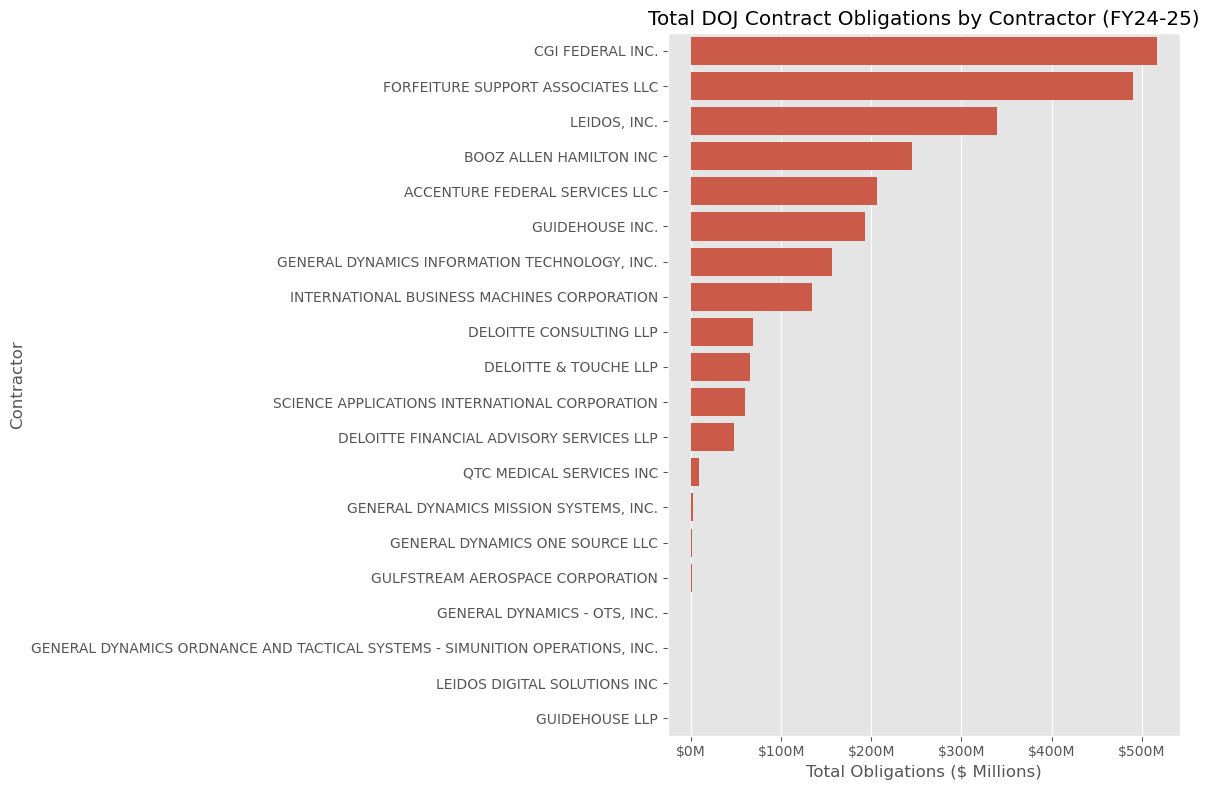

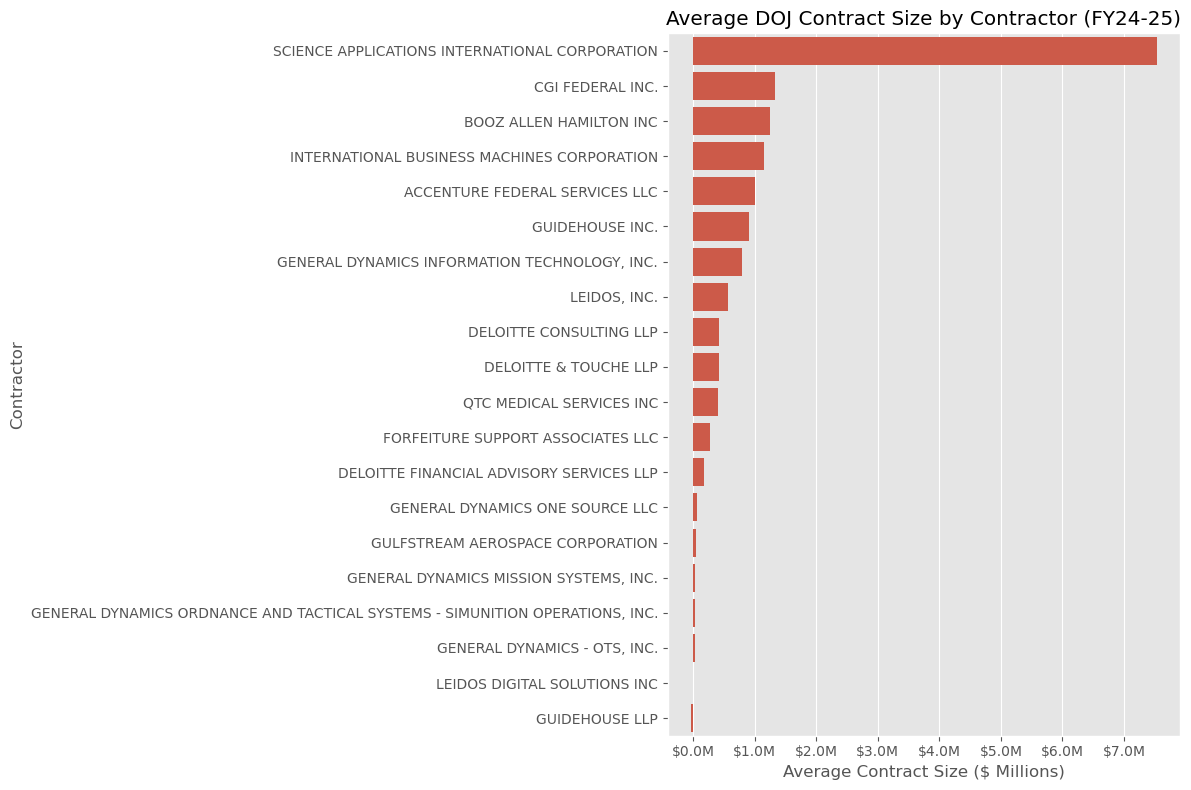

In [12]:
# 1. Contract Volume and Value Analysis
print("\n--- Contract Volume and Value Analysis ---\n")

# Total contract obligations per contractor
total_by_contractor = df_contractors.groupby('recipient_name')['federal_action_obligation'].sum().sort_values(ascending=False)
print("Total Contract Obligations by Contractor:")
display(total_by_contractor)

# Average contract size per contractor
avg_by_contractor = df_contractors.groupby('recipient_name')['federal_action_obligation'].mean().sort_values(ascending=False)
print("\nAverage Contract Size by Contractor:")
display(avg_by_contractor)

# Contract counts by contractor
counts_by_contractor = df_contractors.groupby('recipient_name').size().sort_values(ascending=False)
print("\nNumber of Contracts by Contractor:")
display(counts_by_contractor)

# Calculate total DOJ contract spending in our dataset
total_doj_spending = df_contractors['federal_action_obligation'].sum()
print(f"\nTotal DOJ Contract Spending in Dataset: ${total_doj_spending:,.2f}")

# Calculate percentage of DOJ's spending by contractor
contractor_pct = df_contractors.groupby('recipient_name')['federal_action_obligation'].sum() / total_doj_spending * 100
print("\nPercentage of DOJ Spending by Contractor:")
display(contractor_pct.sort_values(ascending=False))

# Visualize total contract obligations per contractor
plt.figure(figsize=(12, 8))
# Convert values to millions
sns.barplot(x=total_by_contractor.values / 1e6, y=total_by_contractor.index)
plt.title('Total DOJ Contract Obligations by Contractor (FY24-25)')
plt.xlabel('Total Obligations ($ Millions)')
plt.ylabel('Contractor')
# Format x-axis with $ and M
plt.gca().xaxis.set_major_formatter(lambda x, pos: f'${x:.0f}M')
plt.tight_layout()
plt.show()

# Visualize average contract size
plt.figure(figsize=(12, 8))
# Convert values to millions
sns.barplot(x=avg_by_contractor.values / 1e6, y=avg_by_contractor.index)
plt.title('Average DOJ Contract Size by Contractor (FY24-25)')
plt.xlabel('Average Contract Size ($ Millions)')
plt.ylabel('Contractor')
# Format x-axis with $ and M
plt.gca().xaxis.set_major_formatter(lambda x, pos: f'${x:.1f}M')
plt.tight_layout()
plt.show()


--- Portfolio Composition Analysis ---

Percentage of Each Contractor's DOJ Spending by Component:


funding_sub_agency_name,"Bureau of Alcohol, Tobacco, Firearms and Explosives Acquisition and Property Management Division",Drug Enforcement Administration,Federal Bureau of Investigation,Federal Prison System / Bureau of Prisons,Office of Justice Programs,Office of the Inspector General,"Offices, Boards and Divisions",U.S. Marshals Service
recipient_name,,,,,,,,
ACCENTURE FEDERAL SERVICES LLC,0.000000,0.000000e+00,57.174955,11.055891,0.000000,0.00000,31.168277,0.600876
BOOZ ALLEN HAMILTON INC,-0.024866,8.241196e+00,80.773505,0.000000,6.686242,0.00000,4.323923,0.000000
CGI FEDERAL INC.,0.784535,0.000000e+00,2.285854,2.711962,2.707773,0.38695,87.559661,3.563265
DELOITTE & TOUCHE LLP,0.000000,1.062464e+01,68.139438,0.000000,7.491458,0.00000,13.744469,0.000000
DELOITTE CONSULTING LLP,0.072485,-2.899400e-08,9.459533,32.228108,0.000000,0.00000,53.588841,4.651033
DELOITTE FINANCIAL ADVISORY SERVICES LLP,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.00000,100.000000,0.000000
FORFEITURE SUPPORT ASSOCIATES LLC,11.282329,2.660456e+01,13.431739,0.000000,0.000000,0.00000,41.508631,7.172741
"GENERAL DYNAMICS - OTS, INC.",0.000000,0.000000e+00,95.520067,0.000000,0.000000,0.00000,0.000000,4.479933
"GENERAL DYNAMICS INFORMATION TECHNOLOGY, INC.",0.000000,-2.750498e-01,0.297363,0.000000,81.209515,0.00000,18.768172,0.000000



Contract Value by Product/Service Category ($):


product_or_service_code_description,"AIRCRAFT, ROTARY WING","AMMUNITION, THROUGH 30MM",BEHAVIORAL AND MENTAL HEALTH,COMMUNICATIONS SECURITY EQUIPMENT AND COMPONENTS,EDUCATION/TRAINING- GENERAL,HEALTH R&D SERVICES; HEALTH RESEARCH AND TRAINING; BASIC RESEARCH,"INFORMATION TECHNOLOGY CENTRAL PROCESSING UNIT (CPU, COMPUTER, ANALOG)",INFORMATION TECHNOLOGY SOFTWARE,INFORMATION TECHNOLOGY SUPPORT EQUIPMENT,IT AND TELECOM - APPLICATION DEVELOPMENT SOFTWARE (PERPETUAL LICENSE SOFTWARE),IT AND TELECOM - BUSINESS APPLICATION SOFTWARE (PERPETUAL LICENSE SOFTWARE),IT AND TELECOM - BUSINESS APPLICATION/APPLICATION DEVELOPMENT SOFTWARE AS A SERVICE,IT AND TELECOM - BUSINESS APPLICATION/APPLICATION DEVELOPMENT SUPPORT SERVICES (LABOR),IT AND TELECOM - COMPUTE: MAINFRAME (HARDWARE AND PERPETUAL LICENSE SOFTWARE),IT AND TELECOM - DATA CENTER AS A SERVICE,IT AND TELECOM - DATA CENTER PRODUCTS (HARDWARE AND PERPETUAL LICENSE SOFTWARE),"IT AND TELECOM - END USER AS A SERVICE: HELP DESK;TIER 1-2,WORKSPACE,PRINT,OUTPUT,PRODUCTIVITY TOOLS","IT AND TELECOM - END USER: HELP DESK; TIER 1-2, WORKSPACE, PRINT, OUTPUT, PRODUCTIVITY TOOLS (LABOR)","IT AND TELECOM - END USER: HELP DESK;TIER 1-2,WORKSPACE,PRINT,OUTPUT,PRODUCTIVITY TOOLS (HW/PERP SW)",IT AND TELECOM - HIGH PERFORMANCE COMPUTE (HARDWARE AND PERPETUAL LICENSE SOFTWARE),IT AND TELECOM - IT MANAGEMENT SUPPORT SERVICES (LABOR),IT AND TELECOM - IT MANAGEMENT TOOLS/PRODUCTS (HARDWARE AND PERPETUAL LICENSE SOFTWARE),IT AND TELECOM - MOBILE DEVICE SUPPORT SERVICES (LABOR),IT AND TELECOM - NETWORK: DIGITAL NETWORK PRODUCTS (HARDWARE AND PERPETUAL LICENSE SOFTWARE),IT AND TELECOM - NETWORK: SATELLITE COMMUNICATIONS AND TELECOM ACCESS SERVICES,IT AND TELECOM - OTHER DATA CENTER FACILITIES PRODUCTS (HARDWARE AND PERPETUAL LICENSE SOFTWARE),"IT AND TELECOM - PLATFORM SUPPORT SERVICES: DATABASE, MAINFRAME, MIDDLEWARE (LABOR)",IT AND TELECOM - SECURITY AND COMPLIANCE PRODUCTS (HARDWARE AND PERPETUAL LICENSE SOFTWARE),IT AND TELECOM- ANNUAL SOFTWARE MAINTENANCE SERVICE PLANS,IT AND TELECOM- DATA CENTERS AND STORAGE,IT AND TELECOM- FACILITY OPERATION AND MAINTENANCE,IT AND TELECOM- IT STRATEGY AND ARCHITECTURE,IT AND TELECOM- OTHER IT AND TELECOMMUNICATIONS,IT AND TELECOM- SYSTEMS DEVELOPMENT,IT AND TELECOM- TELECOMMUNICATIONS AND TRANSMISSION,MAINT/REPAIR/REBUILD OF EQUIPMENT- AIRCRAFT AND AIRFRAME STRUCTURAL COMPONENTS,MEDICAL- OTHER,MEDICAL- PHYSICAL MEDICINE/REHABILITATION,SPECIAL STUDIES/ANALYSIS- DATA (OTHER THAN SCIENTIFIC),SUPPORT- ADMINISTRATIVE: COURIER/MESSENGER,SUPPORT- ADMINISTRATIVE: INFORMATION RETRIEVAL,SUPPORT- ADMINISTRATIVE: OTHER,SUPPORT- MANAGEMENT: ACCOUNTING,SUPPORT- MANAGEMENT: ADVERTISING,SUPPORT- MANAGEMENT: CONTRACT/PROCUREMENT/ACQUISITION SUPPORT,SUPPORT- MANAGEMENT: DATA COLLECTION,SUPPORT- MANAGEMENT: DEBT COLLECTION,SUPPORT- MANAGEMENT: FINANCIAL,SUPPORT- MANAGEMENT: OTHER,SUPPORT- MANAGEMENT: PUBLIC RELATIONS,SUPPORT- PROFESSIONAL: COMMUNICATIONS,SUPPORT- PROFESSIONAL: ENGINEERING/TECHNICAL,SUPPORT- PROFESSIONAL: EXPERT WITNESS,SUPPORT- PROFESSIONAL: LEGAL,SUPPORT- PROFESSIONAL: OPERATIONS RESEARCH/QUANTITATIVE ANALYSIS,SUPPORT- PROFESSIONAL: OTHER,SUPPORT- PROFESSIONAL: PERSONAL SERVICES CONTRACTS,SUPPORT- PROFESSIONAL: POLICY REVIEW/DEVELOPMENT,SUPPORT- PROFESSIONAL: PROGRAM EVALUATION/REVIEW/DEVELOPMENT,SUPPORT- PROFESSIONAL: PROGRAM MANAGEMENT/SUPPORT,TELEPHONE AND TELEGRAPH EQUIPMENT,VIDEO RECORDING AND REPRODUCING EQUIPMENT
recipient_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ACCENTURE FEDERAL SERVICES LLC,NaN,NaN,NaN,NaN,NaN,1241575.82,NaN,NaN,NaN,NaN,445578.00,188086.08,1.271160e+08,NaN,-213882.9,NaN,NaN,NaN,0.00,NaN,4.365796e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1722509.36,NaN,-514809.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.847941e+05,NaN,8399757.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,18452275.46,NaN,NaN,-48804.16,4.930338e+07,NaN,NaN
BOOZ ALLEN HAMILTON INC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.920311e+08,NaN,NaN,N


Percentage of Each Contractor's DOJ Spending by Contract Type:


naics_description,ADMINISTRATIVE MANAGEMENT AND GENERAL MANAGEMENT CONSULTING SERVICES,AIRCRAFT MANUFACTURING,ALL OTHER LEGAL SERVICES,ALL OTHER OUTPATIENT CARE CENTERS,"ALL OTHER PROFESSIONAL, SCIENTIFIC, AND TECHNICAL SERVICES",ALL OTHER TELECOMMUNICATIONS,AUDIO AND VIDEO EQUIPMENT MANUFACTURING,COMPUTER SYSTEMS DESIGN SERVICES,CUSTOM COMPUTER PROGRAMMING SERVICES,EDUCATIONAL SUPPORT SERVICES,ELECTRONIC COMPUTER MANUFACTURING,ENGINEERING SERVICES,FACILITIES SUPPORT SERVICES,MISCELLANEOUS INTERMEDIATION,OFFICE ADMINISTRATIVE SERVICES,OFFICES OF PHYSICIANS (EXCEPT MENTAL HEALTH SPECIALISTS),OFFICES OF REAL ESTATE APPRAISERS,OTHER ACCOUNTING SERVICES,OTHER COMMUNICATIONS EQUIPMENT MANUFACTURING,OTHER COMPUTER RELATED SERVICES,OTHER SCIENTIFIC AND TECHNICAL CONSULTING SERVICES,OTHER SUPPORT ACTIVITIES FOR AIR TRANSPORTATION,RADIO AND TELEVISION BROADCASTING AND WIRELESS COMMUNICATIONS EQUIPMENT MANUFACTURING,SMALL ARMS AMMUNITION MANUFACTURING,SOFTWARE PUBLISHERS,TELECOMMUNICATIONS RESELLERS,TELEPHONE APPARATUS MANUFACTURING
recipient_name,,,,,,,,,,,,,,,,,,,,,,,,,,,
ACCENTURE FEDERAL SERVICES LLC,8.987264,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.527567e+01,0.091027,0.000000,0.000000,-0.186226,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,5.832265,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
BOOZ ALLEN HAMILTON INC,18.390892,0.000000,-0.000994,0.000000,0.000000,0.000000,0.000000,-1.021712e+00,81.707253,0.000000,0.087965,0.836597,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
CGI FEDERAL INC.,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.285854e+00,0.000000,0.000000,0.000000,0.852743,44.16986,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,52.750870,0.000000,0.000000,0.000000,0.0,-0.059327,0.0,0.000000
DELOITTE & TOUCHE LLP,9.940500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.00000,-1.896574,0.000000,0.000000,0.00000,0.00000,0.000000,92.275847,-0.319772,0.000000,0.000000,0.0,0.000000,0.0,0.000000
DELOITTE CONSULTING LLP,69.925634,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.899400e-08,0.000000,0.034793,0.000000,4.651033,0.00000,0.000000,0.000000,0.000000,0.00000,25.38854,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
DELOITTE FINANCIAL ADVISORY SERVICES LLP,-2.592371,0.000000,103.011839,0.000000,-0.419468,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
FORFEITURE SUPPORT ASSOCIATES LLC,-0.014286,0.000000,97.654995,0.000000,2.275114,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.084178,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
"GENERAL DYNAMICS - OTS, INC.",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,100.0,0.000000,0.0,0.000000
"GENERAL DYNAMICS INFORMATION TECHNOLOGY, INC.",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.437121e+00,96.378896,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,1.183984,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000


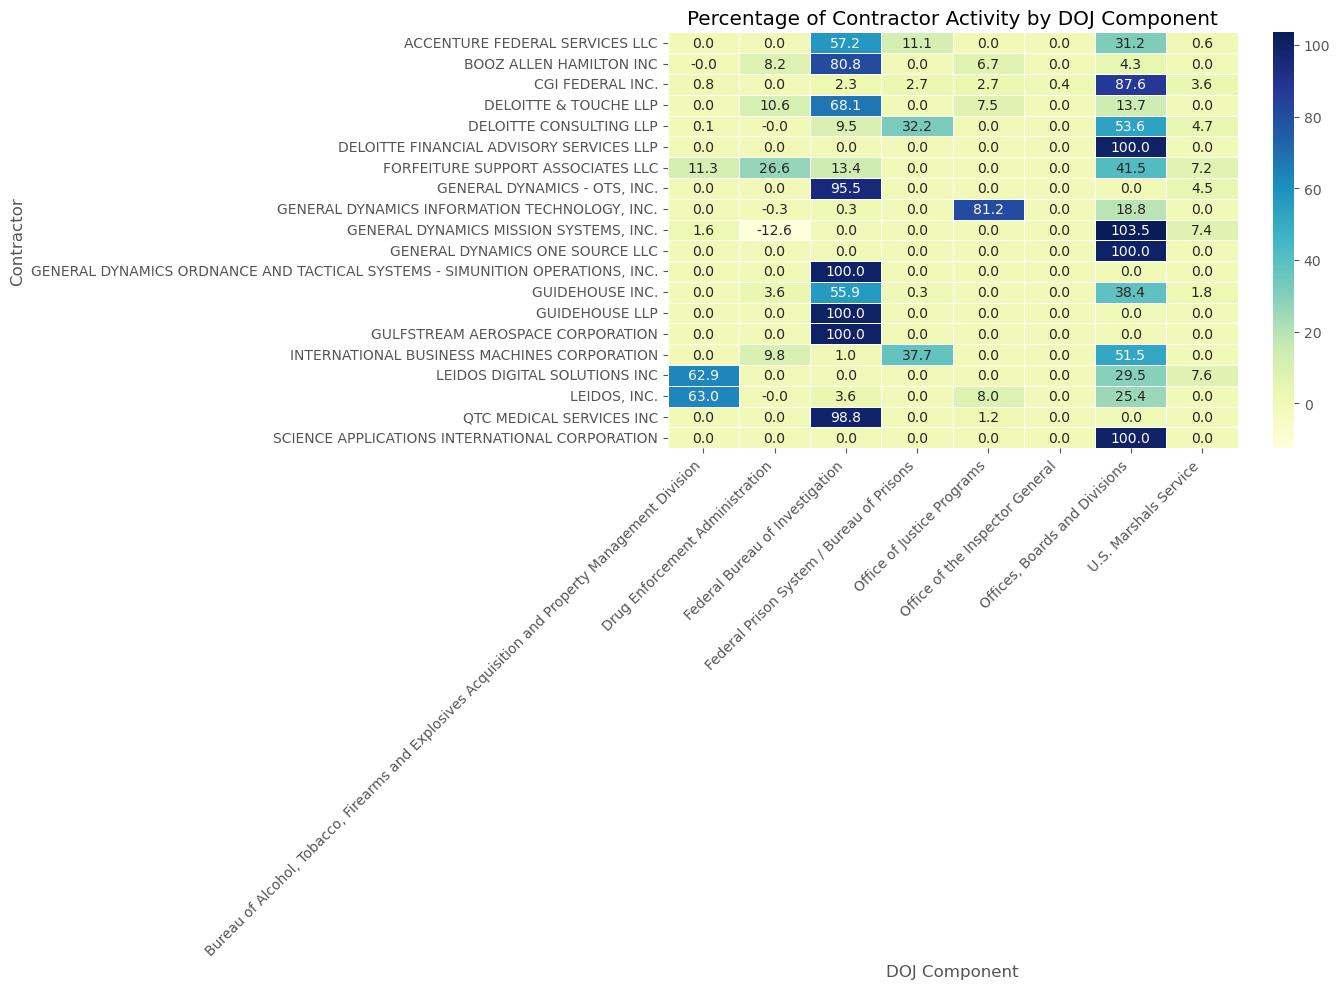

In [16]:
# 2. Portfolio Composition Analysis
print("\n--- Portfolio Composition Analysis ---\n")

# Breakdown by DOJ component
component_breakdown = pd.crosstab(
    df_contractors['recipient_name'], 
    df_contractors['funding_sub_agency_name'], 
    values=df_contractors['federal_action_obligation'], 
    aggfunc='sum',
    normalize='index'
) * 100  # Convert to percentage

print("Percentage of Each Contractor's DOJ Spending by Component:")
display(component_breakdown)

# Distribution across product/service categories
psc_breakdown = pd.crosstab(
    df_contractors['recipient_name'],
    df_contractors['product_or_service_code_description'],
    values=df_contractors['federal_action_obligation'],
    aggfunc='sum'
)

print("\nContract Value by Product/Service Category ($):")
display(psc_breakdown)

# NAICS distribution
contract_types = pd.crosstab(
    df_contractors['recipient_name'],
    df_contractors['naics_description'],
    values=df_contractors['federal_action_obligation'],
    aggfunc='sum',
    normalize='index'
) * 100  # Convert to percentage

print("\nPercentage of Each Contractor's DOJ Spending by Contract Type:")
display(contract_types)

# Create a heatmap for DOJ component activity
plt.figure(figsize=(14, 10))
sns.heatmap(component_breakdown, cmap="YlGnBu", annot=True, fmt='.1f', linewidths=0.5)
plt.title('Percentage of Contractor Activity by DOJ Component')
plt.ylabel('Contractor')
plt.xlabel('DOJ Component')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Treemap of contract categories
# Convert to format needed for treemap
treemap_data = []
for contractor in df_contractors['recipient_name'].unique():
    contractor_df = df_contractors[df_contractors['recipient_name'] == contractor]
    for category in contractor_df['naics_description'].unique():
        value = contractor_df[contractor_df['naics_description'] == category]['federal_action_obligation'].sum()
        treemap_data.append({
            'Contractor': contractor,
            'Category': category.split(':')[1].strip() if ':' in category else category,
            'Value': value
        })

treemap_df = pd.DataFrame(treemap_data)

# Create treemap
fig = px.treemap(
    treemap_df,
    path=['Contractor', 'Category'],
    values='Value',
    title='DOJ Contract Spending by Contractor and NAICS Category'
)
fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))
fig.show()